In [77]:
# imports 
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay 


In [2]:
# read in the data
soccer = pd.read_csv('./data/soccer.csv')
soccer.head()

,subreddit,title,created_utc
0,soccer,Patrice Motsepe (head of CAF) statements after...,1673634624
1,soccer,"Since it hasn't been posted here, the statemen...",1673634572
2,soccer,[Brighton and Hove Albion] Facundo Buonanotte ...,1673634411
3,soccer,PSV see Dynamo Kyiv's Viktor Tsygankov as main...,1673634401
4,soccer,Brighton and Hove Albion offical: Facundo Buon...,1673634201


In [3]:
# read in the data 
world_cup = pd.read_csv('./data/world_cup_no_spam.csv')
world_cup.head()

,subreddit,title,created_utc
0,worldcup,How do some football managers always get the b...,1673632813
1,worldcup,France and Argentina fans… so is it fair to co...,1673621651
2,worldcup,where to the final match ball 2022 with teams ...,1673601825
3,worldcup,Are You Looking For Machine Stitch Trousers In...,1673597142
4,worldcup,World Cup 2026 Preview: How will Brazil fair i...,1673593701


In [4]:
# Combined soccer dataframe and world cup data frame
soccer_world_cup = pd.concat([soccer,world_cup], ignore_index=True)
soccer_world_cup.head()

,subreddit,title,created_utc
0,soccer,Patrice Motsepe (head of CAF) statements after...,1673634624
1,soccer,"Since it hasn't been posted here, the statemen...",1673634572
2,soccer,[Brighton and Hove Albion] Facundo Buonanotte ...,1673634411
3,soccer,PSV see Dynamo Kyiv's Viktor Tsygankov as main...,1673634401
4,soccer,Brighton and Hove Albion offical: Facundo Buon...,1673634201


In [5]:
soccer_world_cup.shape

(1956, 3)

### Random Forest

In [53]:
# Setting up X and y
X = soccer_world_cup['title']
y = soccer_world_cup['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    stratify=y)

In [54]:
# Baseline Accuracy
y_train.value_counts(normalize=True)

soccer      0.511247
worldcup    0.488753
Name: subreddit, dtype: float64

### Baseline Accuracy Described
The baseline accuracy here would be 51% as baseline accuracy is typically set to the majority class. Meaning a value of 52% or higher on accuracy for a model would be scoring better than the baseline. 

In [42]:
rf_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('ss', StandardScaler(with_mean=False)),
    ('rf', RandomForestClassifier())
])

In [43]:
rf_pipe_params = {
    'rf__n_estimators':[25,150],
    'rf__max_depth':[None,2],
    'rf__min_samples_split':[2,5,10],
    'rf__ccp_alpha':[0,.01,.1],
    'cvec__stop_words': ['english'],
    'cvec__max_features': [1000],
    'cvec__min_df': range(1,3,5),
    'cvec__max_df': [.6,.7, .8, ],
    'cvec__ngram_range': [(1,1), (1, 2)]
}

In [44]:
rf_gs = GridSearchCV(rf_pipe, param_grid = rf_pipe_params, n_jobs=-1)

In [45]:
rf_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('ss', StandardScaler(with_mean=False)),
                                       ('rf', RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.6, 0.7, 0.8],
                         'cvec__max_features': [1000],
                         'cvec__min_df': range(1, 3, 5),
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english'],
                         'rf__ccp_alpha': [0, 0.01, 0.1],
                         'rf__max_depth': [None, 2],
                         'rf__min_samples_split': [2, 5, 10],
                         'rf__n_estimators': [25, 150]})

In [47]:
# Getting predictions
y_pred = rf_gs.predict(X_test)

In [79]:
# Accuracy score on test data
rf_gs.score(X_test, y_test)

0.869120654396728

In [80]:
# Accuracy score on the train data
rf_gs.score(X_train, y_train)

0.9679618268575324

In [75]:
# misclassification rate
print(1 - rf_gs.score(X_train, y_train))
print(1 - rf_gs.score(X_test, y_test))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

0.032038173142467596
0.13087934560327197


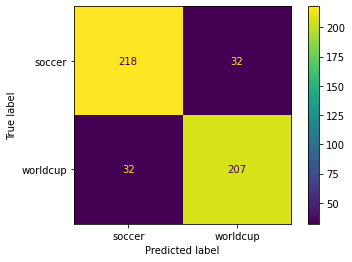

In [78]:
ConfusionMatrixDisplay.from_estimator(rf_gs, X_test, y_test);

### Random Forest Confusion Matrix Described 
The matrix shows the model score well for true negatives and true positives. It did not have that many false positives and false negatives as the number was under 40 for both classes. 

In [14]:
rf_gs.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 1000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'rf__ccp_alpha': 0,
 'rf__max_depth': None,
 'rf__min_samples_split': 2,
 'rf__n_estimators': 150}

### Logistic Regression

In [15]:
lr_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('ss',StandardScaler(with_mean=False)),
    ('lr', LogisticRegression())
])

In [16]:
lr_pipe_params = {
    'lr__C':[.1],
    'cvec__stop_words': ['english'],
    'cvec__max_features': [2000],
    'cvec__min_df': [3],
    'cvec__max_df': [.8],
    'cvec__ngram_range': [(1,1)]
}

In [17]:
lr_gs = GridSearchCV(lr_pipe, param_grid = lr_pipe_params, n_jobs=-1)

In [18]:
lr_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('ss', StandardScaler(with_mean=False)),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.8], 'cvec__max_features': [2000],
                         'cvec__min_df': [3], 'cvec__ngram_range': [(1, 1)],
                         'cvec__stop_words': ['english'], 'lr__C': [0.1]})

In [81]:
# Accuracy score test
lr_gs.score(X_test, y_test)

0.8159509202453987

In [82]:
# Accuracy score train
lr_gs.score(X_train, y_train)

0.9850034083162917

In [83]:
# Getting predictions
y_pred_lr = lr_gs.predict(X_test)

In [87]:
# misclassification rate 
print(1 - lr_gs.score(X_train, y_train))
print(1 - lr_gs.score(X_test, y_test))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_lr).ravel()

0.01499659168370826
0.18404907975460127


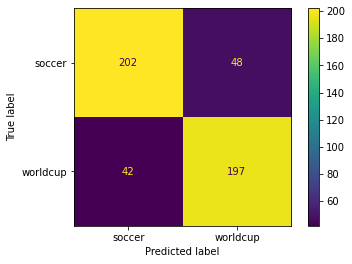

In [88]:
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test, y_test);

### Logistic Regression Confusion Matrix Described
The logistic regression model similarily scored well on true positives and true negatives but scored worse than the random forest model on false positives and false negatives 

In [21]:
lr_gs.best_params_

{'cvec__max_df': 0.8,
 'cvec__max_features': 2000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'lr__C': 0.1}

### KNN Classifier 

In [22]:
knn_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('ss', StandardScaler(with_mean=False)),
    ('knn', KNeighborsClassifier())
])

In [23]:
knn_pipe_params = {
    'knn__n_neighbors':[9],
    'cvec__stop_words':['english'], 
    'cvec__max_features': [2000],
    'cvec__min_df': [1],
    'cvec__max_df': [.7],
    'cvec__ngram_range': [(1,1)]
}

In [24]:
knn_gs = GridSearchCV(knn_pipe, param_grid = knn_pipe_params, n_jobs=-1)

In [25]:
knn_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('ss', StandardScaler(with_mean=False)),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.7], 'cvec__max_features': [2000],
                         'cvec__min_df': [1], 'cvec__ngram_range': [(1, 1)],
                         'cvec__stop_words': ['english'],
                         'knn__n_neighbors': [9]})

In [26]:
# Accuracy score on test
knn_gs.score(X_test, y_test)

0.6298568507157464

In [27]:
# Accuracy score on train
knn_gs.score(X_train, y_train)

0.7634628493524199

In [96]:
# Getting predictions
y_pred_knn = knn_gs.predict(X_test)

In [90]:
# misclassification rate 
print(1 - knn_gs.score(X_train, y_train))
print(1 - knn_gs.score(X_test, y_test))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_knn).ravel()

0.23653715064758007
0.3701431492842536


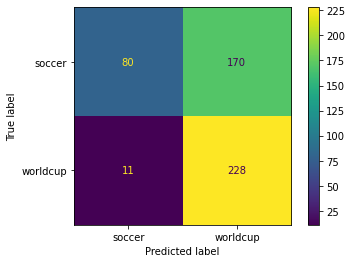

In [91]:
ConfusionMatrixDisplay.from_estimator(knn_gs, X_test, y_test);

### KNN Confusion Matrix Described
The KNN model did not score well on true negatives, false negatives, or false positives. It only scored well on the true positives. This model did not perform that well as evidenced by its 62% accuracy score on the test model. 


In [28]:
knn_gs.best_params_

{'cvec__max_df': 0.7,
 'cvec__max_features': 2000,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__stop_words': 'english',
 'knn__n_neighbors': 9}

### AdaBoost Classifier w/Logistic Regression estimator

In [29]:
boost_pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('ss', StandardScaler(with_mean=False)),
    ('boost', AdaBoostClassifier())
])

In [30]:
boost_pipe_params = {
    'boost__n_estimators': [30, 50, 70],
    'boost__estimator':[LogisticRegression()],
    'cvec__stop_words': ['english'],
    'cvec__max_features': [2000],
    'cvec__min_df': [1,3,5,7],
    'cvec__max_df': [.7, .8, .9],
    'cvec__ngram_range': [(1,1),(1, 2)]
}

In [31]:
# Instantiate Gridsearch
boost_gs = GridSearchCV(boost_pipe, param_grid = boost_pipe_params, n_jobs=-1)

In [32]:
# Fit train data
boost_gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('ss', StandardScaler(with_mean=False)),
                                       ('boost', AdaBoostClassifier())]),
             n_jobs=-1,
             param_grid={'boost__estimator': [LogisticRegression()],
                         'boost__n_estimators': [30, 50, 70],
                         'cvec__max_df': [0.7, 0.8, 0.9],
                         'cvec__max_features': [2000],
                         'cvec__min_df': [1, 3, 5, 7],
                         'cvec__ngram_range': [(1, 1), (1, 2)],
                         'cvec__stop_words': ['english']})

In [33]:
# Accuracy score test 
boost_gs.score(X_test, y_test)

0.8486707566462167

In [34]:
# Accuracy score train
boost_gs.score(X_train, y_train)

0.9959100204498977

In [93]:
# Getting predictions
y_pred_boost = boost_gs.predict(X_test)

In [94]:
# misclassification rate 
print(1 - boost_gs.score(X_train, y_train))
print(1 - boost_gs.score(X_test, y_test))

tn, fp, fn, tp = confusion_matrix(y_test, y_pred_boost).ravel()

0.004089979550102263
0.15132924335378328


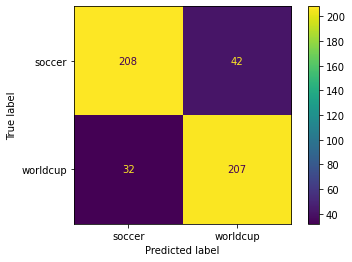

In [95]:
ConfusionMatrixDisplay.from_estimator(boost_gs, X_test, y_test);

### Adaboost Confusion Matrix Described
The adaboost model performed well for true positives and true negatives. The false positives lagged 10 points behind the false negative but overall a much better predictor than the KNN model. 

### Conclusions for Models

Though none of the models had accuracy scores above 90%, overall, the models performed well. Three of the four models had accuracy scores above 80 and the random forest model scored the highest at 86.9%. The most disappointing model was the KNN model that only had a 62% accuracy score and poor misclassification rate. Out of all the models the best one would be the random forest model. Though it is overfit, it scored best out of all the models on identify true positives and tied for the highest in identifying true negatives. The random forest model also had the lowere false negatives and false positives out of all the other models. 

### Recommendations
Since the majority of models scored above 80% on accuracy FIFA can still stand to make good profits from having the subreddits seperate. If it was much harder to make a model to score at least 80% than the commonalities would have been enough to warrant combining them into one. For the next steps, on top of funding moderators for the world cup subreddit there could possibly be another subreddit made specifically for FIFA world cup 2026. This way moderating help would be easier to fund and the overall data on posts would be new enough to manage and leverage relevant advertisements. 